# カフェのサービス評価実験 - 分析

## ライブラリとデータの挿入と整理

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
original = pd.read_csv("data.csv", header=0)

In [4]:
fa_data = original.iloc[:, 2:24]
human = original[original["店員"] == "人"]
fa_data_human = human.iloc[:, 2:24]
robot = original[original["店員"] == "ロボット"]
fa_data_robot = robot.iloc[:, 2:24]

aov_data = original.iloc[:, 24:]

## 因子分析

## 全体

###  数値変換

In [5]:
for i in range(len(fa_data.columns)):
    if "ない" in fa_data.columns[i]:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "2")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "6")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "2")
        
    fa_data = fa_data.rename({str(fa_data.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].astype(int)
    
for i in range(len(fa_data_human.columns)):
    if "ない" in fa_data_human.columns[i]:
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("強くそう思う", "1")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("ややそう思う", "3")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("そう思う", "2")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("どちらともいえない", "4")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("ややそう思わない", "5")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("全くそう思わない", "7")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("強くそう思う", "7")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("ややそう思う", "5")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("そう思う", "6")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("どちらともいえない", "4")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("ややそう思わない", "3")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("全くそう思わない", "1")
        fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].str.replace("そう思わない", "2")
        
    fa_data_human = fa_data_human.rename({str(fa_data_human.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data_human[fa_data_human.columns[i]] = fa_data_human[fa_data_human.columns[i]].astype(int)
    
for i in range(len(fa_data_robot.columns)):
    if "ない" in fa_data_robot.columns[i]:
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("強くそう思う", "1")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("ややそう思う", "3")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("そう思う", "2")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("どちらともいえない", "4")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("ややそう思わない", "5")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("全くそう思わない", "7")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("強くそう思う", "7")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("ややそう思う", "5")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("そう思う", "6")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("どちらともいえない", "4")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("ややそう思わない", "3")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("全くそう思わない", "1")
        fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].str.replace("そう思わない", "2")
        
    fa_data_robot = fa_data_robot.rename({str(fa_data_robot.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data_robot[fa_data_robot.columns[i]] = fa_data_robot[fa_data_robot.columns[i]].astype(int)

In [6]:
fa_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
mean,5,4.21053,5.68421,4.10526,5.73684,4.63158,4.31579,6.05263,5.26316,3,...,4.31579,4.73684,4.52632,6.21053,5.05263,4.10526,4.15789,4.78947,4,4.15789
std,1.85592,1.54844,1.66842,1.79179,1.24017,1.97795,1.73374,1.17727,1.408,1.69967,...,1.94515,1.6945,2.1697,1.18223,1.74718,1.82254,2.03479,2.04339,1.97203,1.06787
min,1,2,1,1,2,1,1,2,3,1,...,1,1,1,2,2,1,1,1,1,2
25%,4,3,5,3,5,3,3.5,6,4,2,...,3,4,2.5,6,3.5,3,2,3,2.5,4
50%,6,4,6,4,6,5,5,6,6,3,...,5,5,5,6,6,4,5,6,5,4
75%,6,5.5,7,5.5,6.5,6,5,7,6,3.5,...,6,6,6,7,6,5.5,6,6,5,4.5
max,7,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [7]:
fa_data_human.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
mean,3.66667,4.44444,6.55556,4.33333,5.55556,5.55556,5.11111,6,4.88889,2.88889,...,5.33333,5,5.22222,6.66667,5,4,4.88889,4.55556,4.33333,4.11111
std,1.80278,1.81046,0.726483,2,1.66667,1.74005,1.16667,1.58114,1.53659,2.02759,...,1.87083,1.80278,1.56347,0.5,1.80278,2.17945,1.90029,2.12786,2,1.2693
min,1,2,5,1,2,3,3,2,3,1,...,1,2,2,6,2,1,2,1,1,2
25%,2,3,6,3,5,4,5,6,4,1,...,5,5,5,6,4,3,4,3,3,4
50%,4,5,7,5,6,6,5,6,5,2,...,6,6,5,7,6,3,5,6,5,4
75%,5,6,7,6,7,7,6,7,6,4,...,6,6,6,7,6,6,6,6,6,4
max,6,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [8]:
fa_data_robot.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
mean,6.2,4,4.9,3.9,5.9,3.8,3.6,6.1,5.6,3.1,...,3.4,4.5,3.9,5.8,5.1,4.2,3.5,5,3.7,4.2
std,0.788811,1.33333,1.91195,1.66333,0.737865,1.8738,1.89737,0.737865,1.26491,1.44914,...,1.57762,1.64992,2.5144,1.47573,1.79196,1.54919,2.01384,2.0548,2.00278,0.918937
min,5,2,1,1,5,1,1,5,3,1,...,1,1,1,2,2,2,1,1,1,3
25%,6,3,5,3,5.25,2.25,2,6,5.25,2.25,...,2.25,3.5,1.25,6,3.5,3,2,3.5,2.25,4
50%,6,4,5.5,4,6,3.5,4.5,6,6,3,...,3,5,4.5,6,6,5,2.5,5.5,4,4
75%,7,4.75,6,4,6,5.75,5,6.75,6,3,...,4.75,5.75,6,6.75,6,5,5.75,6.75,5,4.75
max,7,6,7,7,7,6,6,7,7,6,...,6,6,7,7,7,6,6,7,7,6


### 標準化

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(fa_data)

z = sc.transform(fa_data)

sc = StandardScaler()
sc.fit(fa_data_human)

z_human = sc.transform(fa_data_human)

sc = StandardScaler()
sc.fit(fa_data_robot)

z_robot = sc.transform(fa_data_robot)

### 主成分分析

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(z)


PCA()

In [11]:
pca_human = PCA()
pca_human.fit(z_human)

PCA()

In [12]:
pca_robot = PCA()
pca_robot.fit(z_robot)

PCA()

### 因子数の決定

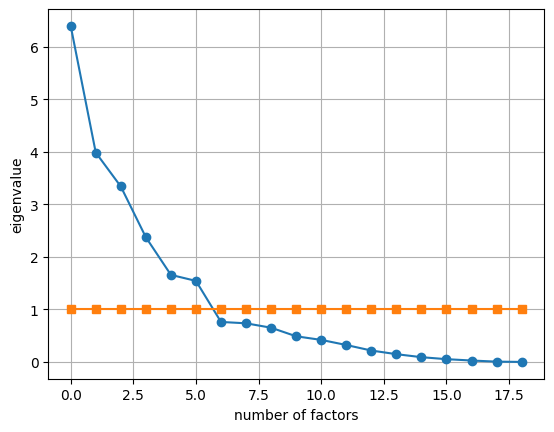

In [13]:
ev = pca.explained_variance_

ev_1 = np.ones(19)

plt.plot(ev, 'o-')
plt.plot(ev_1, 's-')

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()

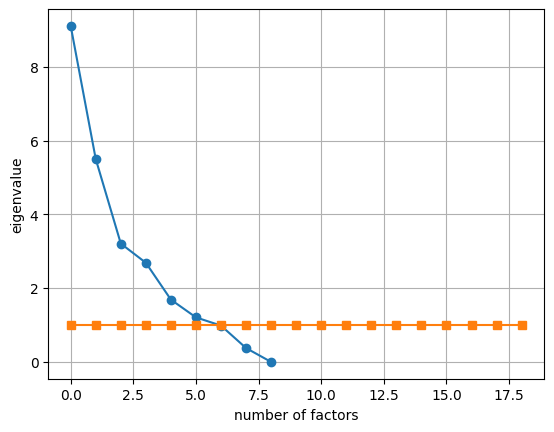

In [14]:
ev = pca_human.explained_variance_

ev_1 = np.ones(19)

plt.plot(ev, 'o-')
plt.plot(ev_1, 's-')

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()

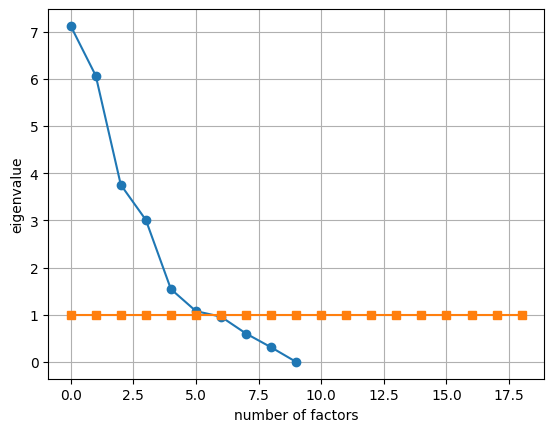

In [15]:
ev = pca_robot.explained_variance_

ev_1 = np.ones(19)

plt.plot(ev, 'o-')
plt.plot(ev_1, 's-')

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()

In [16]:
from sklearn.decomposition import FactorAnalysis as FA

n_components = 6

fa = FA(n_components, max_iter=5000)
fitted = fa.fit_transform(z)

print(fitted)
print(fitted.shape)


[[ 0.89381855  2.35746109 -1.62198636  0.1105228  -1.49554137  0.07944356]
 [-0.20442112  0.6796288   0.08705687 -0.36666516 -0.24916421 -0.57853316]
 [ 1.90449414 -1.04755286  0.60154105  0.44676934 -0.70855303 -1.03064706]
 [ 1.27052972 -0.75952233 -0.4300938  -1.4102963  -0.39498308  2.02540599]
 [ 0.95847426 -1.48803924 -1.48126004 -0.84777192  0.61808258 -0.38242892]
 [-1.04952328 -0.04086787 -1.0484585   0.94797457  0.43033852 -0.32572144]
 [ 1.30832421  1.18857847  0.12238814  1.7866152   0.0838773  -0.52480426]
 [-0.33460919 -0.87770406 -0.82312381 -0.09267292 -0.57609919  0.2930612 ]
 [ 0.69886273 -0.63870294  0.5342673  -0.37026877 -0.2285234  -0.03930069]
 [-0.46219592 -0.22461501 -0.95262835  0.66673919  0.38069729  0.23585791]
 [-0.10770392 -1.57891459  1.20936574  0.42522092 -0.8701531  -1.56420325]
 [-0.3538454  -0.4839539   1.53654068  2.00551565  0.40574732  2.5898461 ]
 [-1.46825927 -0.632333   -0.63204696  0.53360462 -0.72053124 -0.08109964]
 [ 0.54158894  0.39708595

In [17]:
n_components = 6

fa_human = FA(n_components, max_iter=5000)
fitted_human = fa_human.fit_transform(z_human)

print(fitted_human)
print(fitted_human.shape)

[[ 1.77075648  1.33582722  0.4955412   0.82246488  0.54177747 -1.21873141]
 [ 0.4625711   0.17534215  0.17890862  0.87706525  0.65531111  2.43151252]
 [ 0.88919393 -1.0017336  -1.09422572 -1.10861624  0.24320258 -0.66375004]
 [-0.88769983  1.46055755 -1.73643321  0.17797056 -1.3769907   0.08030962]
 [-0.25292154 -0.27575281  1.88470763 -0.68831057 -1.59898961  0.03042363]
 [-1.74245441  0.84760944  0.67313253 -0.69852297  1.67931888 -0.48292956]
 [-0.162789   -1.25626877 -0.68148788 -0.31545768  0.73687474  0.17613522]
 [-0.72465393 -1.29418352  0.12486249  2.01490512 -0.37237763 -0.81479624]
 [ 0.6479972   0.00860233  0.15499434 -1.08149836 -0.50812682  0.46182626]]
(9, 6)


In [18]:
n_components = 6

fa_robot = FA(n_components, max_iter=5000)
fitted_robot = fa_robot.fit_transform(z_robot)

print(fitted_robot)
print(fitted_robot.shape)

[[ 1.22592736  0.05019037 -1.2728043  -0.28999947 -1.19965359  0.03647361]
 [ 1.93456431 -0.72534815  0.86644962  1.03188601  0.44054863 -0.17018904]
 [ 0.26738785 -1.31668547 -0.49430386 -0.26418928 -1.11196163 -0.66631045]
 [-0.90781588 -1.3670293   0.40636113 -0.25784342  0.04533089  2.21593981]
 [-0.20151513  0.33266007 -0.24555491 -0.72817879  1.1931275  -1.38350977]
 [ 0.52515761  0.64416699  0.58012948  0.48126409  1.65669886  0.54402802]
 [-1.1850622  -0.85086937 -1.00223818 -0.51199316  1.04637082 -0.68583146]
 [ 0.33044109  1.87454994 -0.35998398 -1.38171764 -0.30296699  1.015167  ]
 [-1.15271018  0.98046176 -0.74366648  2.36244811 -0.59791043 -0.01293107]
 [-0.83637483  0.37790317  2.26561147 -0.44167645 -1.16958406 -0.89283665]]
(10, 6)


### 因子負荷量行列

In [19]:
Factor_loading_matrix = fa.components_.T

res = pd.DataFrame(
    Factor_loading_matrix,
    columns=["first", "second", "third", "fourth", "fifth", "sixth"],
    index=[fa_data.columns]
)

cm = sns.light_palette("red", as_cmap=True)
res.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
X1,0.232892,-0.489121,-0.559011,0.439420,-0.414426,0.022427
X2,0.058475,0.321898,-0.646615,0.430335,0.510441,-0.029644
X3,-0.105159,0.312824,-0.267003,-0.127614,0.135512,-0.820431
X4,0.286756,0.395442,-0.560890,0.317035,0.210212,0.179556
X5,-0.395668,-0.084887,-0.058476,0.280141,-0.605242,0.073600
X6,-0.520949,0.104868,-0.476821,-0.409122,0.130432,-0.148245
X7,-0.336156,0.312364,-0.651195,-0.426199,-0.016948,0.073809
X8,-0.161121,0.237425,0.113209,0.249087,-0.683759,0.072224
X9,0.132905,-0.090561,-0.261702,-0.000475,-0.462665,-0.369928
X10,-0.262713,0.113211,-0.461104,0.581066,-0.269446,0.168860


In [20]:
Factor_loading_matrix_human = fa_human.components_.T

res_human = pd.DataFrame(
    Factor_loading_matrix_human,
    columns=["first", "second", "third", "fourth", "fifth", "sixth"],
    index=[fa_data_human.columns]
)
res_human.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
X1,0.959197,-0.125713,-0.112658,-0.212830,0.073321,-0.027182
X2,0.511474,0.257296,-0.792441,-0.044042,-0.138036,-0.075917
X3,0.259603,-0.049430,-0.745820,0.512075,0.328788,-0.006447
X4,0.759178,0.259976,-0.574787,0.109540,-0.115651,0.016087
X5,0.371332,-0.583727,0.413919,0.053346,0.242134,-0.463772
X6,0.318058,0.142348,0.029525,0.244828,-0.769788,-0.397257
X7,0.727322,-0.048123,0.025899,0.037172,-0.432970,-0.458250
X8,0.282397,-0.280195,0.758625,-0.029754,0.505752,0.032724
X9,0.473742,-0.167447,0.318620,0.507817,0.053001,-0.400555
X10,0.879286,-0.053281,-0.106239,-0.297444,0.170337,-0.302983


In [21]:
Factor_loading_matrix_robot = fa_robot.components_.T

res_robot = pd.DataFrame(
    Factor_loading_matrix_robot,
    columns=["first", "second", "third", "fourth", "fifth", "sixth"],
    index=[fa_data_robot.columns]
)
res_robot.style.background_gradient(cmap=cm)

,first,second,third,fourth,fifth,sixth
X1,0.144719,-0.291390,0.055655,-0.610392,-0.447243,-0.459326
X2,-0.653398,-0.748716,-0.090114,-0.020838,0.061647,-0.003695
X3,-0.046636,-0.189850,0.023480,-0.851514,-0.208442,0.088454
X4,0.012560,-0.689544,0.106497,0.358688,0.161653,0.271048
X5,-0.505856,0.400939,-0.047285,0.095066,-0.558582,-0.499364
X6,-0.181534,0.076846,0.322786,-0.512037,0.007148,-0.549010
X7,0.103658,-0.323344,0.403482,-0.152410,0.520643,-0.637966
X8,-0.815044,-0.165179,-0.398018,0.011352,-0.229065,0.163334
X9,0.229886,-0.311946,0.182363,-0.645984,-0.208905,0.457741
X10,-0.744853,0.190620,0.378927,0.218786,-0.296998,-0.248451


## 定量的分析

### 正規性検定

In [22]:
from scipy.stats import shapiro

W, shapiro_p_value = shapiro(aov_data["金額"])
print(f'Shapiro-Wilk test statistic: {W}, p-value: {shapiro_p_value}')

Shapiro-Wilk test statistic: 0.89255690574646, p-value: 0.035751406103372574


### t検定

In [25]:
from scipy.stats import mannwhitneyu

human = aov_data[aov_data["店員"] == "人"]
robot = aov_data[aov_data["店員"] == "ロボット"]

stat, p = mannwhitneyu(human["金額"], robot["金額"])

print("t = %f, p-value = %f"%(stat,p))

t = 53.500000, p-value = 0.509893


### 一要因分散分析

In [26]:
from scipy.stats import kruskal

h, p = kruskal(human["金額"], robot["金額"])
print("H = %f, p-value = %f"%(h,p))

H = 0.490268, p-value = 0.483808
